<a href="https://colab.research.google.com/github/aayushmanace/Multivehicle_teams/blob/main/Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## $Conflict$ $Based$ $Interval$ $Tree$

In [ ]:
!pip install intervaltree
!pip install ortools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from intervaltree import Interval, IntervalTree

class Appointment(Interval):
    def __new__(cls, begin, end, start_delay=None, end_delay=None, full=None, server=None):
        instance = super().__new__(cls, begin, end)
        instance.start_delay_interval = start_delay
        instance.end_delay_interval = end_delay
        instance.service_interval = (begin, end)
        instance.server = server
        return instance

appointment1 = Appointment(0, 5)
appointment2 = Appointment(3, 8)
appointment3 = Appointment(6, 10)

tree = IntervalTree()
tree.add(appointment1)
tree.add(appointment2)
tree.add(appointment3)

search_interval = Appointment(2, 7)
overlapping_intervals = tree.overlap(search_interval)


for interval in overlapping_intervals:
    print(f"Appointment [{interval.begin}, {interval.end}] overlaps with the search Appointment.")




Appointment [3, 8] overlaps with the search Appointment.
Appointment [6, 10] overlaps with the search Appointment.
Appointment [0, 5] overlaps with the search Appointment.


In [ ]:
p = []
for i in tree:
  p.append(i)
p.append(search_interval)  


In [ ]:
p

[Interval(3, 8), Interval(6, 10), Interval(0, 5), Interval(2, 7)]

In [ ]:
c = tree.overlap(search_interval.begin, search_interval.end)
if c:
  print(c)

{Interval(3, 8), Interval(6, 10), Interval(0, 5)}


There is an interval tree for each
charging pad for handling server-based conflicts, while there
are two individual interval trees for handling delay-based and
reachability-based conflicts

In total there are $c_{r^g}$+2 interval trees 

In [ ]:
from ortools.sat.python import cp_model
from intervaltree import Interval, IntervalTree

def makespan(conflicts):
    # Define the solver and model
    solver = cp_model.CpSolver()
    model = cp_model.CpModel()

    # Get the maximum end time of all conflicting intervals
    max_end_time = max([max([interval.end for interval in conflict]) for conflict in conflicts])

    # Define the variables
    start_time = model.NewIntVar(0, max_end_time, 'start_time')

    # Define the constraints
    for interval_list in conflicts:
        for interval in interval_list:
            model.Add(start_time >= interval.end)

    # Define the objective
    model.Minimize(start_time)

    # Solve the problem
    status = solver.Solve(model)

    # Return the optimal start time if feasible solution is found, otherwise return -1
    if status == cp_model.OPTIMAL:
        return solver.Value(start_time)
    else:
        return -1


In [ ]:
conflicts = [
    [Interval(1, 3), Interval(4, 6), Interval(8, 10)],
    [Interval(2, 5), Interval(7, 9)],
    [Interval(2, 4), Interval(6, 8), Interval(9, 11)]
]

print(makespan(conflicts))


11


In [ ]:
#@title Trial
class ConflictBasedIntervalTree:
    def __init__(self, server_interval_trees, delay_interval_tree, reach_interval_tree):
        # Initialize the ConflictBasedIntervalTree with server, delay, and reach interval trees
        self.server_interval_trees = server_interval_trees
        self.delay_interval_tree = delay_interval_tree
        self.reach_interval_tree = reach_interval_tree

    def add_to_cbi_tree(self, A):
        while True:
            # Initialize conflict lists for checking conflicts with server, delay, and reach intervals
            conflict_list = []
            server_conflict_list = []
            best_server = None

            # Check for conflicts in each server interval tree
            for t in self.server_interval_trees:
                conflicts = t.overlap(A.begin, A.end)
                # If there is a conflict, add it to the server conflict list
                if conflicts:
                    server_conflict_list.append(conflicts)
                else:
                    # If there is no conflict, the server is considered the best server
                    best_server = t

            # Check for conflicts in the delay interval tree for the start delay interval
            start_delay_conflicts = self.delay_interval_tree.overlap(A.start_delay_interval[0], A.start_delay_interval[1])
            if start_delay_conflicts:
                conflict_list.append(start_delay_conflicts)

            # Check for conflicts in the delay interval tree for the end delay interval
            end_delay_conflicts = self.delay_interval_tree.overlap(A.end_delay_interval[0], A.end_delay_interval[1])
            if end_delay_conflicts:
                conflict_list.append(end_delay_conflicts)

            # Check for conflicts in the reach interval tree for the full interval
            reach_conflicts = self.reach_interval_tree.overlap(A.service_interval[0], A.service_interval[1])
            if reach_conflicts:
                conflict_list.append(reach_conflicts)

            # If there are no conflicts in any of the lists, add the appointment to the best server
            if not conflict_list and not server_conflict_list:
                A.server = best_server
                best_server.add(A)
                self.delay_interval_tree.add(Interval(A.start_delay_interval[0], A.start_delay_interval[1]))
                self.delay_interval_tree.add(Interval(A.end_delay_interval[0], A.end_delay_interval[1]))
                return A
            else:
                # If there are conflicts, update the start time of the appointment based on the makespan function
                #A.begin = makespan(conflict_list + server_conflict_list)
                new_begin = makespan(conflict_list + server_conflict_list)
                new_A = Appointment(new_begin, A.end, A.start_delay_interval, A.end_delay_interval, A.service_interval)
                self.add_to_cbi_tree(new_A)

In [ ]:
class ConflictBasedIntervalTree:
    def __init__(self, server_interval_trees, delay_interval_tree, reach_interval_tree):
        # Initialize the ConflictBasedIntervalTree with server, delay, and reach interval trees
        self.server_interval_trees = server_interval_trees
        self.delay_interval_tree = delay_interval_tree
        self.reach_interval_tree = reach_interval_tree

    def add_to_cbi_tree(self, A):
        stack = [A]

        while stack:
            A = stack.pop()

            # Initialize conflict lists for checking conflicts with server, delay, and reach intervals
            conflict_list = []
            server_conflict_list = []
            best_server = None

            # Check for conflicts in each server interval tree
            for t in self.server_interval_trees:
                conflicts = t.overlap(A.begin, A.end)
                # If there is a conflict, add it to the server conflict list
                if conflicts:
                    server_conflict_list.append(conflicts)
                else:
                    # If there is no conflict, the server is considered the best server
                    best_server = t

            # Check for conflicts in the delay interval tree for the start delay interval
            start_delay_conflicts = self.delay_interval_tree.overlap(A.start_delay_interval[0], A.start_delay_interval[1])
            if start_delay_conflicts:
                conflict_list.append(start_delay_conflicts)

            # Check for conflicts in the delay interval tree for the end delay interval
            end_delay_conflicts = self.delay_interval_tree.overlap(A.end_delay_interval[0], A.end_delay_interval[1])
            if end_delay_conflicts:
                conflict_list.append(end_delay_conflicts)

            # Check for conflicts in the reach interval tree for the full interval
            reach_conflicts = self.reach_interval_tree.overlap(A.service_interval[0], A.service_interval[1])
            if reach_conflicts:
                conflict_list.append(reach_conflicts)

            # If there are no conflicts in any of the lists, add the appointment to the best server
            if not conflict_list and not server_conflict_list:
                A.server = best_server
                best_server.add(A)
                self.delay_interval_tree.add(Interval(A.start_delay_interval[0], A.start_delay_interval[1]))
                self.delay_interval_tree.add(Interval(A.end_delay_interval[0], A.end_delay_interval[1]))
            else:
                # If there are conflicts, update the start time of the appointment based on the makespan function
                new_begin = makespan(conflict_list + server_conflict_list)
                new_A = Appointment(new_begin, A.end, A.start_delay_interval, A.end_delay_interval, A.service_interval)
                stack.append(new_A)
                
    def print_appointments_without_conflicts(self):
        for tree in self.server_interval_trees:
            for appointment in tree.appointments:
                if not any([
                    self.delay_interval_tree.overlap(appointment.start_delay_interval[0], appointment.start_delay_interval[1]),
                    self.delay_interval_tree.overlap(appointment.end_delay_interval[0], appointment.end_delay_interval[1]),
                    self.reach_interval_tree.overlap(appointment.service_interval[0], appointment.service_interval[1])
                ]):
                    print(appointment)


In [ ]:
class Interval:
    def __init__(self, begin, end):
        self.begin = begin
        self.end = end


class IntervalTree:
    def __init__(self):
        self.intervals = []
        self.appointments = []


    def overlap(self, begin, end):
        conflicts = [interval for interval in self.intervals if interval.begin < end and interval.end > begin]
        return conflicts

    def add(self, interval, appointment=None):
        self.intervals.append(interval)
        if appointment is not None:
            self.appointments.append(appointment)


class Appointment:
    def __init__(self, begin, end, start_delay_interval, end_delay_interval, service_interval):
        self.begin = begin
        self.end = end
        self.start_delay_interval = start_delay_interval
        self.end_delay_interval = end_delay_interval
        self.service_interval = service_interval
        self.server = None


def makespan(conflicts):
    flattened_conflicts = [interval for conflict in conflicts for interval in conflict]
    return max(interval.end for interval in flattened_conflicts)



# Create server, delay, and reach interval trees
server_interval_tree = IntervalTree()
delay_interval_tree = IntervalTree()
reach_interval_tree = IntervalTree()

cbi_tree = ConflictBasedIntervalTree([server_interval_tree], delay_interval_tree, reach_interval_tree)

A1 = Appointment(0, 10, (0, 5), (10, 15), (0, 10))
A2 = Appointment(3, 12, (3, 8), (12, 17), (3, 12))
A3 = Appointment(15, 25, (15, 20), (25, 30), (15, 25))

# Add appointments to the conflict-based interval tree
cbi_tree.add_to_cbi_tree(A1)
cbi_tree.add_to_cbi_tree(A2)
cbi_tree.add_to_cbi_tree(A3)

# Print appointments without conflicts
print("Appointments without conflicts:")
cbi_tree.print_appointments_without_conflicts()

KeyboardInterrupt: ignored

In [ ]:
A.service_interval

(0, 10)

In [ ]:

# Create server, delay, and reach interval trees using the intervaltree library
server_trees = [IntervalTree() for _ in range(3)]  # Assuming 3 server interval trees
delay_tree = IntervalTree()
reach_tree = IntervalTree()

# Create some appointment objects
appointment1 = Appointment(0, 5, (1,2), (1,2), (0,5),"A")
appointment2 = Appointment(3, 8, (1,2), (1,2), (3,8),"A")
appointment3 = Appointment(6, 10, (1,2), (1,2), (6,10),"B")

# Initialize the ConflictBasedIntervalTree with the server, delay, and reach interval trees
cbi_tree = ConflictBasedIntervalTree(server_trees, delay_tree, reach_tree)

# Add the appointments to the ConflictBasedIntervalTree
cbi_tree.add_to_cbi_tree(appointment1)
"""
cbi_tree.add_to_cbi_tree(appointment2)  
cbi_tree.add_to_cbi_tree(appointment3)


# Print the server assignments for each appointment
print(f"Appointment 1: Server {appointment1.server}")
print(f"Appointment 2: Server {appointment2.server}")
print(f"Appointment 3: Server {appointment3.server}")
"""

'\ncbi_tree.add_to_cbi_tree(appointment2)  \ncbi_tree.add_to_cbi_tree(appointment3)\n\n\n# Print the server assignments for each appointment\nprint(f"Appointment 1: Server {appointment1.server}")\nprint(f"Appointment 2: Server {appointment2.server}")\nprint(f"Appointment 3: Server {appointment3.server}")\n'

In [ ]:
cbi_tree.add_to_cbi_tree(appointment2)

In [ ]:
cbi_tree.server_interval_trees

In [ ]:
from intervaltree import Interval, IntervalTree

class Appointment(Interval):
    def __init__(self, begin, end, start_delay_interval, end_delay_interval, service_interval):
        super().__init__(begin, end)
        self.start_delay_interval = start_delay_interval
        self.end_delay_interval = end_delay_interval
        self.service_interval = service_interval
        self.server = None


def makespan(intervals):
    if not intervals:
        return 0
    end_times = [interval.end for interval in intervals]
    return max(end_times)

class ConflictBasedIntervalTree:
    def __init__(self, server_interval_trees, delay_interval_tree, reach_interval_tree):
        # Initialize the ConflictBasedIntervalTree with server, delay, and reach interval trees
        self.server_interval_trees = server_interval_trees
        self.delay_interval_tree = delay_interval_tree
        self.reach_interval_tree = reach_interval_tree

    def add_to_cbi_tree(self, A):
        stack = [A]

        while stack:
            A = stack.pop()

            # Initialize conflict lists for checking conflicts with server, delay, and reach intervals
            conflict_list = []
            server_conflict_list = []
            best_server = None

            # Check for conflicts in each server interval tree
            for t in self.server_interval_trees:
                conflicts = t.overlap(A.begin, A.end)
                # If there is a conflict, add it to the server conflict list
                if conflicts:
                    server_conflict_list.append(conflicts)
                else:
                    # If there is no conflict, the server is considered the best server
                    best_server = t

            # Check for conflicts in the delay interval tree for the start delay interval
            start_delay_conflicts = self.delay_interval_tree.overlap(A.start_delay_interval[0], A.start_delay_interval[1])
            if start_delay_conflicts:
                conflict_list.append(start_delay_conflicts)

            # Check for conflicts in the delay interval tree for the end delay interval
            end_delay_conflicts = self.delay_interval_tree.overlap(A.end_delay_interval[0], A.end_delay_interval[1])
            if end_delay_conflicts:
                conflict_list.append(end_delay_conflicts)

            # Check for conflicts in the reach interval tree for the full interval
            reach_conflicts = self.reach_interval_tree.overlap(A.service_interval[0], A.service_interval[1])
            if reach_conflicts:
                conflict_list.append(reach_conflicts)

            # If there are no conflicts in any of the lists, add the appointment to the best server
            if not conflict_list and not server_conflict_list:
                A.server = best_server
                best_server.add(A)
                self.delay_interval_tree.add(Interval(A.start_delay_interval[0], A.start_delay_interval[1]))
                self.delay_interval_tree.add(Interval(A.end_delay_interval[0], A.end_delay_interval[1]))
            else:
                # If there are conflicts, update the start time of the appointment based on the makespan function
                new_begin = makespan(conflict_list + server_conflict_list)
                new_A = Appointment(new_begin, A.end, A.start_delay_interval, A.end_delay_interval, A.service_interval)
                stack.append(new_A)

# Create server, delay, and reach interval trees using the intervaltree library
server_trees = [IntervalTree() for _ in range(3)]  # Assuming 3 server interval trees
delay_tree = IntervalTree()
reach_tree = IntervalTree()

# Create some appointment objects
appointment1 = Appointment(0, 5, (1,2), (1,2), (0,5))
appointment2 = Appointment(3, 8, (1,2), (1,2), (3,8))
appointment3 = Appointment(6, 10, (1,2), (1,2), (6,10))

# Initialize the ConflictBasedIntervalTree with the server, delay, and reach interval trees
cbi_tree = ConflictBasedIntervalTree(server_trees, delay_tree, reach_tree)


# Add the appointments to the ConflictBasedIntervalTree
cbi_tree.add_to_cbi_tree(appointment1)
cbi_tree.add_to_cbi_tree(appointment2)  
cbi_tree.add_to_cbi_tree(appointment3)

print(f"Appointment 1: Server {appointment1.server}")
print(f"Appointment 2: Server {appointment2.server}")
print(f"Appointment 3: Server {appointment3.server}")


## $2-Phase$ $Scheduling$

In [ ]:
def scheduleCorrection(Mrg, ra, tc):
    # Get most recent predicted appointment of ra
    A = None
    for appt in reversed(Mrg):
        if isinstance(appt, Appointment) and appt.server == ra:
            A = appt
            break
    
    if A is None:
        # No predicted appointment for ra found, return None
        return None
    
    # Update appointment with new start and end times
    A.begin = tc
    A.end = tc + A.end - A.begin
    
    # Update the clockTime of the appointment
    A.clockTime = A.end
    
    # Add takeoff milestone to Mrg
    m = Milestone()
    m.x = None
    m.clockTime = A.end
    Mrg.append(m)
    
    # Sort Mrg by clockTime
    Mrg.sort(key=lambda m: m.clockTime)
    
    return m

In [ ]:
class Server:
    def __init__(self, id):
        self.id = id

class Appointment:
    def __init__(self, begin: int, end: int, server: str):
        self.begin = begin
        self.end = end
        self.server = server
        self.clockTime = end  # Initialize clockTime to end time


class Milestone:
    def __init__(self, x=None, clockTime=0):
        self.x = x
        self.clockTime = clockTime

def scheduleCorrection(Mrg, ra, tc):
    # Get most recent predicted appointment of ra
    A = None
    for appt in reversed(Mrg):
        if isinstance(appt, Appointment) and appt.server == ra:
            A = appt
            break
    
    if A is None:
        # No predicted appointment for ra found, return None
        return None
    
    # Update appointment with new start and end times
    A.begin = tc
    A.end = tc + A.end - A.begin
    
    # Update the clockTime of the appointment
    A.clockTime = A.end
    
    # Add takeoff milestone to Mrg
    m = Milestone()
    m.x = None
    m.clockTime = A.end
    Mrg.append(m)
    
    # Sort Mrg by clockTime
    Mrg.sort(key=lambda m: m.clockTime)
    
    return m



In [ ]:
# Initialize the merge list with some appointments and milestones
Mrg = [
    Appointment(0, 5, 'A'),
    Milestone(clockTime=5),
    Appointment(6, 10, 'B'),
    Milestone(clockTime=10)
]

# Call the scheduleCorrection function with ra='A' and tc=2
new_milestone = scheduleCorrection(Mrg, 'A', 2)

# Print the updated merge list
for item in Mrg:
    print(type(item), item.clockTime)

# Output:
# <class '__main__.Appointment'> 2
# <class '__main__.Milestone'> 5
# <class '__main__.Appointment'> 6
# <class '__main__.Milestone'> 10
# <class '__main__.Milestone'> 5


<class '__main__.Appointment'> 5
<class '__main__.Milestone'> 5
<class '__main__.Milestone'> 5
<class '__main__.Appointment'> 10
<class '__main__.Milestone'> 10


In [ ]:
Mrg

In [ ]:
# Create some appointment objects
appointment1 = Appointment(0, 5, (1,2), (1,2), (0,5))
appointment2 = Appointment(3, 8, (1,2), (1,2), (3,8))
appointment3 = Appointment(6, 10, (1,2), (1,2), (6,10))

# Add the appointments to the ConflictBasedIntervalTree
cbi_tree.add_to_cbi_tree(appointment1)
appointment1.clockTime = appointment1.end  # Set the clockTime attribute
cbi_tree.add_to_cbi_tree(appointment2)  
appointment2.clockTime = appointment2.end  # Set the clockTime attribute
cbi_tree.add_to_cbi_tree(appointment3)
appointment3.clockTime = appointment3.end  # Set the clockTime attribute

# Create an empty milestone list
Mrg = []

# Add the appointments to the milestone list
Mrg.append(appointment1)
Mrg.append(appointment2)
Mrg.append(appointment3)


KeyboardInterrupt: ignored

## $Milestone$ $Path$ $Planning$

In [ ]:
from collections import defaultdict

class MRG:
    def __init__(self):
        self.milestones = []
        self.adj_list = defaultdict(list)

    def add_milestone(self, milestone):
        # Add milestone to MRG and update adjacency list
        self.milestones.append(milestone)
        for i, m in enumerate(self.milestones[:-1]):
            if m.clock_time <= milestone.clock_time:
                self.adj_list[i].append(len(self.milestones)-1)
            else:
                self.adj_list[len(self.milestones)-1].append(i)

    def get_previous_milestones(self, index):
        # Get previous milestones for given index
        return [self.milestones[i] for i in self.adj_list[index]]


In [ ]:
def planTakeoffRendez(C, ra, rg, Prg, Prg_max, slim, reachIT):
    # Get current time
    tc = time.time()

    # Schedule correction and prediction appointments
    Tnew = scheduleCorrection(rg.M, ra, tc)
    Rnew = schedulePrediction(C, rg.M, ra, tc)

    # Get indices of correction and prediction appointments in Mrg
    Tindex = rg.M.index(Tnew) if Tnew is not None else len(rg.M)
    Rindex = rg.M.index(Rnew)

    # Add existing appointments to the ConflictBasedIntervalTree
    for a in rg.M:
        cbi_tree.add_to_cbi_tree(a)

    # Sample takeoff and rendezvous points
    S = set()
    while len(S) < slim:
        if Rindex < len(rg.M):
            # Sample takeoff point from Prg and rendezvous point from UGV's reachability set
            s = sample_takeoff_rendezvous(Prg, reachIT, rg.M, Tindex, Rindex)
        elif Tindex >= len(rg.M.milestones):
            # Sample takeoff and rendezvous points from UGV's reachability set
            s = sample_takeoff_rendezvous(reachIT, reachIT, rg.M, Tindex, Rindex)
        else:
            # Sample takeoff and rendezvous points from Prg
            s = sample_takeoff_rendezvous(Prg, Prg, rg.M, Tindex, Rindex)

        # Add sampled appointment to the ConflictBasedIntervalTree
        A = Appointment(s.takeoff, s.rendezvous, s.start_delay_interval, s.end_delay_interval, s.full_interval, None)
        cbi_tree.add_to_cbi_tree(A)

        # Check if the appointment conflicts with any existing appointments
        overlapping_intervals = cbi_tree.overlap(A)
        if overlapping_intervals:
            # If there is a conflict, update the start time of the appointment based on the makespan function
            A.begin = makespan(overlapping_intervals)

        # Add the appointment to the set of sampled appointments
        S.add(s)

    # Find best takeoff and rendezvous point based on reward function
    best_s, Prg_a = max((s, rg.reward_func(s)) for s in S)

    # Update Prg and Mrg with best takeoff and rendezvous point
    Tnew = Appointment(best_s.takeoff, best_s.takeoff + C.service_time, None, None, None, None)
    Rnew = Appointment(best_s.rendezvous - C.service_time, best_s.rendezvous, None, None, None, None)
    rg.M.append(Tnew)
    rg.M.append(Rnew)

    # Add the new appointments to the ConflictBasedIntervalTree
    cbi_tree.add_to_cbi_tree(Tnew)
    cbi_tree.add_to_cbi_tree(Rnew)

    # Update reachability interval tree
    reachIT.add_interval(Interval(best_s.reachability))

    # Return updated Prg and Pr_a
    return Prg, Prg_a


## $Milestone$

In [ ]:
import time

class Milestone:
    def __init__(self, is_takeoff, is_rendez, clock_time, ra):
        self.is_takeoff = is_takeoff
        self.is_rendez = is_rendez
        self.clock_time = clock_time
        self.ra = ra

## $UAV$

In [ ]:
class Vehicle:
    def __init__(self):
        self.milestones = []
        self.path = []
        self.ready_list = []
        self.charging_list = []

    def is_close_to(self, milestone):
        # Implement a method to check if the vehicle is close to the given milestone
        pass

    def adjust_path(self):
        # Implement a method to adjust the vehicle's path after removing a milestone
        pass

    def brake(self, delta_stagger):
        time.sleep(delta_stagger)
    """
    def generate_random_path(self, n_points, x_range=(0, 100), y_range=(0, 100)):
        self.path = [(random.uniform(x_range[0], x_range[1]), random.uniform(y_range[0], y_range[1])) for _ in range(n_points)]
    """



## $UGV$

## $Plav$

In [ ]:
import time

def planTakeoffRendez(C, ra, rg, Prg, Prg_max, slim, reachIT):
    # Get current time
    tc = time.time()
    
    # Schedule correction and prediction appointments
    Tnew = scheduleCorrection(rg.M, ra, tc)
    Rnew = schedulePrediction(C, rg.M, ra, tc)
    
    # Get indices of correction and prediction appointments in Mrg
    Tindex = rg.M.index(Tnew) if Tnew is not None else len(rg.M)
    Rindex = rg.M.index(Rnew)
    
    # Sample takeoff and rendezvous points
    S = set()
    while len(S) < slim:
        if Rindex < len(rg.M):
            # Sample takeoff point from Prg and rendezvous point from UGV's reachability set
            s = sample_takeoff_rendezvous(Prg, reachIT, rg.M, Tindex, Rindex)
        elif Tindex >= len(rg.M.milestones):
            # Sample takeoff and rendezvous points from UGV's reachability set
            s = sample_takeoff_rendezvous(reachIT, reachIT, rg.M, Tindex, Rindex)
        else:
            # Sample takeoff and rendezvous points from Prg
            s = sample_takeoff_rendezvous(Prg, Prg, rg.M, Tindex, Rindex)
        S.add(s)
    
    # Find best takeoff and rendezvous point based on reward function
    best_s, Prg_a = max((s, rg.reward_func(s)) for s in S)
    
    # Update Prg and Mrg with best takeoff and rendezvous point
    Prg, rg.M = update_Prg_Mrg(Prg, rg.M, Tnew, Rnew, best_s)
    
    # Update reachability interval tree
    reachIT.add_interval(Interval(best_s.reachability))
    
    # Return updated Prg and Pr_a
    return Prg, Prg_a


In [ ]:
#!pip install intervaltree 
#!pip install portion
#uncomment and install if not installed

In [ ]:
def makespan(conflicts):
    max_time = 0

    for conflict in conflicts:
        if conflict:  # Ensure there is a conflict before checking its time
            conflict_end_time = conflict.end  # Assuming 'end' attribute represents the end time of the conflict
            max_time = max(max_time, conflict_end_time)

    return max_time


In [ ]:
class RG:
    def __init__(self, id, position, milestones, ready_list=None, charging_list=None):
        self.id = id
        self.position = position
        self.milestones = milestones
        self.ready_list = ready_list if ready_list is not None else []
        self.charging_list = charging_list if charging_list is not None else []
        self.awaiting_mission = True

    def is_close_to(self, milestone):
        # Implement a method to check if the vehicle is close to the given milestone
        pass

    def adjust_path(self):
        # Implement a method to adjust the vehicle's path after removing a milestone
        pass

    def brake(self, delta_stagger):
        time.sleep(delta_stagger)

    def send_next_path_segment(self):
        # Implement a method to send the next path segment to the vehicle
        pass

    def send_go_command(self):
        # Implement a method to send the go command to the vehicle
        pass


In [ ]:
class RA:
    def __init__(self, id, position,speed_limit, energy_limit, flight_status=None):
        self.id = id
        self.position = position
        self.flight_status = flight_status if flight_status is not None else "ground" #"ground" or "air"
        self.speed_limit = speed_limit
        self.energy_limit = energy_limit
        self.current_energy = energy_limit
        self.distance = 0

    def predict_appointment(self, speed, distance):
        # Discharge power curve
        P_discharge = 0.0461 * (speed**3) - 0.5834 * (speed**2) - 1.876 * speed + 229.6

        # Time to travel the distance
        travel_time = distance / speed

        # Energy consumption during travel
        E_travel = P_discharge * travel_time

        # Energy consumption for landing and take-off
        E_landing = 7.2
        E_takeoff = 4.0

        # Total energy consumption
        E_total = E_travel + E_landing + E_takeoff

        # Check if the energy consumption is within the limit
        if E_total <= self.energy_limit:
            # Calculate appointment duration based on energy consumption and charging power curve
            if E_total <= 270.4:
                charging_power = 310.8
            else:
                charging_power = 19.965 * (287700 - E_total)

            charging_time = E_total / charging_power
            appointment_duration = travel_time + charging_time

            return appointment_duration
        else:
            # Return None if energy consumption exceeds the limit
            return None

    def take_off(self):
        # Implement a method for the UAV to take off
        pass

    def land(self):
        # Implement a method for the UAV to land
        pass

    def upload_plans(self, plans):
        # Implement a method to upload plans to the UAV
        pass

    def fly_to(self, destination):
        # Implement a method for the UAV to fly to a specific destination
        pass

    def is_ready(self):
        # Implement a method to check if the UAV is ready for the next mission
        pass


In [ ]:
import time

def deployment(C, ugv_list, uav_list):
    while True:
        for rg in ugv_list:
            m = rg.milestones[0]

            if rg.is_close_to(m):
                if m.is_takeoff or time.time() >= m.clock_time:
                    upload_plans(m.ra)
                    rg.milestones.pop(0)
                    rg.adjust_path()

                elif m.is_rendez or time.time() >= m.clock_time:
                    delta_stagger = m.clock_time - time.time()
                    rg.brake(delta_stagger)

                    if m.ra in rg.ready_list:
                        send_land_command(m.ra)
                        rg.charging_list.append(m.ra)
                        rg.milestones.pop(0)
                        rg.adjust_path()

                        plan_takeoff_rendez(C, m.ra, rg)

                    else:
                        rg.brake()
            else:
                if rg.awaiting_mission:
                    send_next_path_segment(rg)
                    send_go_command(rg)


Note that you'll need to implement the following functions and integrate them with your existing classes for the code to work:



1. upload_plans 
2. send_land_command

3. plan_takeoff_rendez

4. send_next_path_segment
5. send_go_command
6. List item



In [ ]:
def upload_plans(uav):
    print(f"Uploading plans to UAV {uav}")
    # Implement the logic to upload plans to the specified UAV

def send_land_command(uav):
    print(f"Sending land command to UAV {uav}")
    # Implement the logic to send a land command to the specified UAV


In [ ]:
 def schedule_correction(Mr_g, ra, tc):
    A = get_most_recent_predicted_appointment(ra)
    A.update(tc)
    A.predicted = False
    m = add_takeoff_milestone(Mr_g, A.service_interval.right)
    Mr_g.sort(key=lambda x: x.clock_time)
    return m

def schedule_prediction(C, Mr_g, ra, tc):
    A = create_appointment_using_takeoff_time(tc)
    A.predicted = True
    A = cbi_tree.add_to_cbi_tree(C, A)
    m = add_rendezvous_milestone(Mr_g, A.start_time)
    Mr_g.sort(key=lambda x: x.clock_time)
    return m


In [ ]:
def plan_takeoff_rendez(C, ra, rg, Pr_g, Pr_g):
    tc = time.time()
    Tnew = schedule_correction(Mr_g, ra, tc)
    Rnew = schedule_prediction(C, Mr_g, ra, tc)
    Tindex = Mr_g.index(Tnew)
    Rindex = Mr_g.index(Rnew)
    S = set()
    
    while len(S) < slim:
        if Rindex < len(Mr_g):
            s = sample_takeoff_rendezvous_points(Pr_g, rg, Tindex, Rindex)
        elif Tindex > len(Mr_g.milestones):
            s = sample_takeoff_rendezvous_points_reachability(rg, Tindex, Rindex)
        else:
            s = sample_takeoff_rendezvous_points_existing(Pr_g, rg, Tindex, Rindex)
        
        S.add(s)
    
    s_star, Pr_a = max([(s, Pr_a) for s in S], key=lambda x: reward_function(x[0]))
    update_path_and_milestones(Pr_g, Mr_g, s_star)
    update_reach_it()
    
    return Pr_g, Pr_a


## $P_{r^g}$

In [ ]:
def Prg(C, rg, reachIT):
    # Initialize a list to store all possible takeoff points
    P = []

    # Iterate over each path segment in rg
    for i in range(len(rg.path) - 1):
        # Get the start and end positions of the path segment
        start_pos = rg.path[i]
        end_pos = rg.path[i + 1]

        # Calculate the distance and duration of the path segment
        distance = start_pos.distance_to(end_pos)
        duration = distance / rg.max_speed

        # Iterate over each time step in the path segment
        for j in range(int(duration / C.delta_t) + 1):
            # Calculate the time at the current time step
            t = rg.t_start + (i * duration) + (j * C.delta_t)

            # Calculate the position at the current time step
            pos = start_pos.interpolate(end_pos, j * C.delta_t / duration)

            # Calculate the estimated energy at the current time step
            e = rg.battery.capacity - rg.battery.consumption(t, start_pos, pos)

            # If the estimated energy is greater than or equal to the energy threshold, add the takeoff point to P
            if e >= C.energy_threshold:
                # Calculate the delay times for the start delay interval and end delay interval
                start_delay = max(0, C.min_start_delay - (rg.t_start - t))
                end_delay = max(0, C.min_end_delay - (rg.t_end - (t + duration)))

                # Calculate the full interval for the appointment
                full_interval = (t + start_delay, t + duration + end_delay)

                # Check if the appointment conflicts with any existing appointments in the reachability interval tree
                overlapping_intervals = reachIT.search(full_interval[0], full_interval[1])
                if not overlapping_intervals:
                    # If there are no conflicts, add the appointment to P
                    P.append(TakeoffPoint(pos, e, start_delay, end_delay, full_interval))

    return P


## Construction of Path

In [ ]:
#@title RRT
class KinodynamicRRT:
    def __init__(self, x0, goal, N):
        self.x0 = tuple(x0)
        self.goal = tuple(goal)
        self.N = N
        self.tree = {self.x0: None}

    def sample(self):
        # Implement your sampling method here
        pass

    def nearest(self, x_rand):
        # Implement your nearest method here
        pass

    def choose_control(self, x_near, x_rand):
        # Implement your control selection method here
        pass

    def simulate(self, x_near, u_e):
        # Implement your simulation method here
        pass

    def is_collision_free(self, x_near, x_e):
        # Implement your collision check method here
        pass

    def plan(self):
        for i in range(self.N):
            x_rand = self.sample()
            x_near = self.nearest(x_rand)
            u_e = self.choose_control(x_near, x_rand)
            x_e = self.simulate(x_near, u_e)

            if self.is_collision_free(x_near, x_e):
                self.tree[x_e] = x_near

                if x_e == self.goal:
                    return self.reconstruct_path(x_e)

        return "no path"

    def reconstruct_path(self, x_e):
        path = [x_e]
        while x_e is not None:
            x_e = self.tree[x_e]
            path.append(x_e)
        return path[::-1]

"""
class KinodynamicRRT:
    def __init__(self, x0, goal, N):
        self.x0 = x0
        self.goal = goal
        self.N = N
        self.tree = {x0: None}
"""




'\nclass KinodynamicRRT:\n    def __init__(self, x0, goal, N):\n        self.x0 = x0\n        self.goal = goal\n        self.N = N\n        self.tree = {x0: None}\n'

In [ ]:
#@title Default title text
import numpy as np
import matplotlib.pyplot as plt
from random import uniform

class ToyKinodynamicRRT(KinodynamicRRT):
    def __init__(self, x0, goal, N, xlim, ylim):
        super().__init__(x0, goal, N)
        self.xlim = xlim
        self.ylim = ylim

    def sample(self):
        return np.array([uniform(self.xlim[0], self.xlim[1]), uniform(self.ylim[0], self.ylim[1])])

    def nearest(self, x_rand):
        return min(self.tree.keys(), key=lambda x: np.linalg.norm(x - x_rand))

    def choose_control(self, x_near, x_rand):
        return (x_rand - x_near) * 0.1

    def simulate(self, x_near, u_e):
        return x_near + u_e

    def is_collision_free(self, x_near, x_e):
        # In this toy example, we assume no obstacles
        return True

def plot_path(rrt, path):
    plt.scatter(*zip(*rrt.tree.keys()), label='Vertices')
    for child, parent in rrt.tree.items():
        if parent is not None:
            plt.plot(*zip(child, parent), 'b-')

    plt.plot(*zip(*path), 'r', linewidth=2, label='Path')
    plt.scatter(*rrt.x0, marker='*', color='green', s=200, label='Start')
    plt.scatter(*rrt.goal, marker='*', color='red', s=200, label='Goal')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    x0 = np.array([0, 0])
    goal = np.array([9, 9])
    N = 1000
    xlim = (0, 10)
    ylim = (0, 10)

    rrt = ToyKinodynamicRRT(x0, goal, N, xlim, ylim)
    path = rrt.plan()
    plot_path(rrt, path)


Path found!



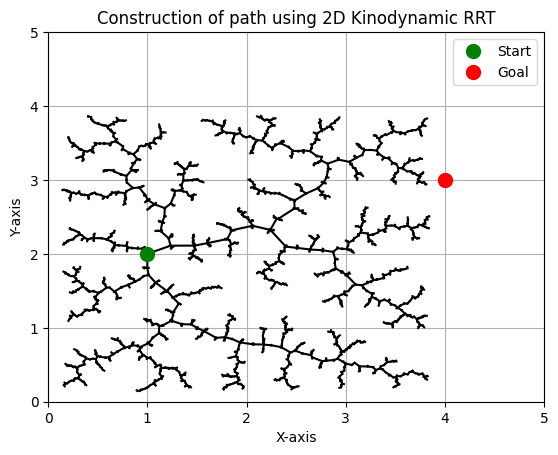

In [ ]:
#@title RRT 
import numpy as np
import random
import matplotlib.pyplot as plt

p = 4
# Parameters
x0 = np.array([1, 2])
goal = np.array([4,3])
N = 6000

def sample():
    return np.array([random.uniform(0, p), random.uniform(0, p)])

def nearest(T, x_rand):
    return min(T, key=lambda x: np.linalg.norm(x - x_rand))

def choose_control(x_near, x_rand):
    return (x_rand - x_near) * 0.1

def simulate(x_near, u_e):
    return x_near + u_e

def is_collision_free(x_near, x_e):
    # There are no obstacles in this example, so it's always collision-free
    return True

def reconstruct_path(tree, x_e):
    path = [x_e]
    while x_e is not None:
        x_e = tree[x_e]
        path.append(x_e)
    return path[::-1]


# RRT algorithm
tree = {tuple(x0): None}

for i in range(N):
    x_rand = sample()
    x_near = nearest(tree.keys(), x_rand)
    u_e = choose_control(x_near, x_rand)
    x_e = simulate(x_near, u_e)

    if is_collision_free(x_near, x_e):
        tree[tuple(x_e)] = x_near

        if np.linalg.norm(x_e - goal) < 0.2:
            print("Path found!")
            print("")
            path = reconstruct_path(tree, tuple(x_e))
            break
else:
    print("No path found")
    print("")

# Plotting the results
plt.figure()
for x, parent in tree.items():
    if parent is not None:
        plt.plot([x[0], parent[0]], [x[1], parent[1]], 'k-')

if 'path' in locals() and path is not None:
    #path = path[:-1]  # Remove the 'None' value at the end
    #path_x, path_y = zip(*path)
    path_x = path_y = [path[1:][i][0] for i in range(len(path[1:]))],[path[1:][i][1] for i in range(len(path[1:]))]
    #plt.plot(path_x, path_y, 'r')


plt.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
plt.plot(goal[0], goal[1], 'ro', markersize=10, label='Goal')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Construction of path using 2D Kinodynamic RRT')
plt.grid(True)
plt.axis([0, p+1, 0, p+1])
plt.show()


In [ ]:
#@title RRT
import numpy as np
import random
import matplotlib.pyplot as plt


def kinodynamic_rrt(x0, goal, N=6000, p=4):
    def sample():
        return np.array([random.uniform(0, p), random.uniform(0, p)])

    def nearest(T, x_rand):
        return min(T, key=lambda x: np.linalg.norm(x - x_rand))

    def choose_control(x_near, x_rand):
        return (x_rand - x_near) * 0.1

    def simulate(x_near, u_e):
        return x_near + u_e

    def is_collision_free(x_near, x_e):
        # There are no obstacles in this example, so it's always collision-free
        return True

    def reconstruct_path(tree, x_e):
        path = [x_e]
        while x_e is not None:
            x_e = tree[x_e]
            path.append(x_e)
        return path[::-1]

    # RRT algorithm
    tree = {tuple(x0): None}

    for i in range(N):
        x_rand = sample()
        x_near = nearest(tree.keys(), x_rand)
        u_e = choose_control(x_near, x_rand)
        x_e = simulate(x_near, u_e)

        if is_collision_free(x_near, x_e):
            tree[tuple(x_e)] = x_near

            if np.linalg.norm(x_e - goal) < 0.2:
                print("Path found!")
                print("")
                path = reconstruct_path(tree, tuple(x_e))
                break
    else:
        print("No path found")
        print("")

    # Plotting the results
    plt.figure()
    """
    for x, parent in tree.items():
        if parent is not None:
            plt.plot([x[0], parent[0]], [x[1], parent[1]], 'k-')
    """

    if 'path' in locals() and path is not None:
        #path = path[:-1]  # Remove the 'None' value at the end
        #path_x, path_y = zip(*path)
        path_x = path_y = [path[1:][i][0] for i in range(len(path[1:]))],[path[1:][i][1] for i in range(len(path[1:]))]
        plt.plot(path_x, path_y, 'r')

    plt.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
    plt.plot(goal[0], goal[1], 'ro', markersize=10, label='Goal')
    plt.legend()
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Construction of path using 2D Kinodynamic RRT')
    plt.grid(True)
    plt.axis([0, p+1, 0, p+1])
    plt.show()

    return path if 'path' in locals() and path is not None else None


In [ ]:
#@title RRT
import numpy as np
import random
import matplotlib.pyplot as plt

def rrt_path_planning(x0, milestones, p=4, N=6000):
    # Parameters
    goal = milestones[-1]

    def sample():
        return np.array([random.uniform(0, p), random.uniform(0, p)])

    def nearest(T, x_rand):
        return min(T, key=lambda x: np.linalg.norm(x - x_rand))

    def choose_control(x_near, x_rand):
        return (x_rand - x_near) * 0.1

    def simulate(x_near, u_e):
        return x_near + u_e

    def is_collision_free(x_near, x_e):
        # There are no obstacles in this example, so it's always collision-free
        return True

    def reconstruct_path(tree, x_e):
        path = [x_e]
        while x_e is not None:
            x_e = tree[x_e]
            path.append(x_e)
        return path[::-1]

    # RRT algorithm
    tree = {tuple(x0): None}
    start = x0

    for i in range(N):
        x_rand = sample()
        x_near = nearest(tree.keys(), x_rand)
        u_e = choose_control(x_near, x_rand)
        x_e = simulate(x_near, u_e)

        if is_collision_free(x_near, x_e):
            tree[tuple(x_e)] = x_near

            if np.linalg.norm(x_e - goal) < 0.2:
                print("Path found!")
                print("")
                path = reconstruct_path(tree, tuple(x_e))
                break

        start = milestones[i] if i < len(milestones) else start

    else:
        print("No path found")
        print("")

    # Plotting the results
    plt.figure()
    """
    for x, parent in tree.items():
        if parent is not None:
           plt.plot([x[0], parent[0]], [x[1], parent[1]], 'k-')
    """

    if 'path' in locals() and path is not None:
        path_x = [start[0]] + [path[1:][i][0] for i in range(len(path[1:]))]
        path_y = [start[1]] + [path[1:][i][1] for i in range(len(path[1:]))]
        plt.plot(path_x, path_y, 'r')

    plt.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
    plt.plot(goal[0], goal[1], 'ro', markersize=10, label='Goal')
    for i, milestone in enumerate(milestones[:-1]):
        plt.plot(milestone[0], milestone[1], 'yo', markersize=10, label='Milestone'+str(i))
    plt.legend()
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Construction of path using 2D Kinodynamic RRT')
    plt.grid(True)
    plt.axis([0, p+1, 0, p+1])
    plt.show()

# Example usage
x0 = np.array([1, 2])
milestones = [np.array([2, 3]), np.array([3, 2]), np.array([4, 3])]
rrt_path_planning(x0, milestones)


Path found to milestone!



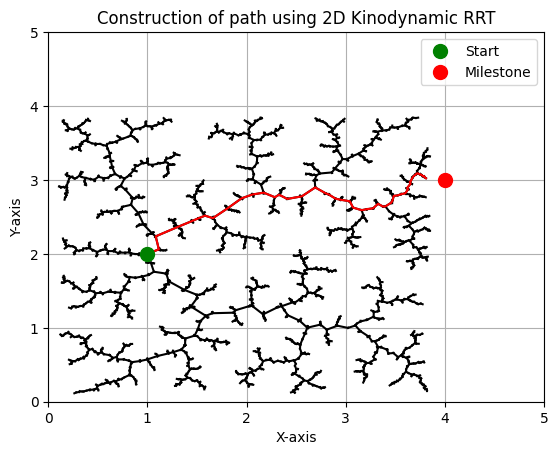

Path found to milestone!



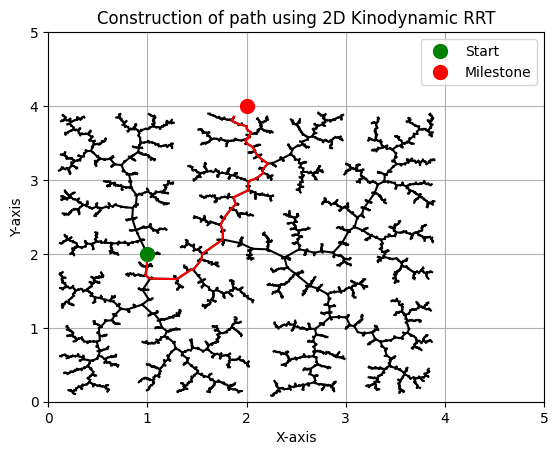

Path found to milestone!



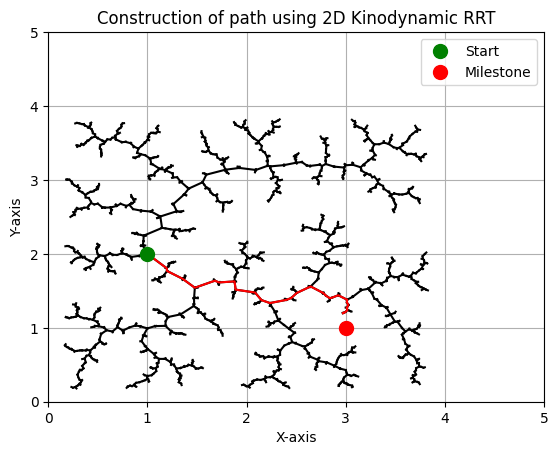

In [ ]:
#@title RRT Construction
import numpy as np
import random
import matplotlib.pyplot as plt

p = 4
# Parameters
x0 = np.array([1, 2])
milestones = [np.array([4,3]), np.array([2,4]), np.array([3,1])]
N = 6000

def sample():
    return np.array([random.uniform(0, p), random.uniform(0, p)])

def nearest(T, x_rand):
    return min(T, key=lambda x: np.linalg.norm(x - x_rand))

def choose_control(x_near, x_rand):
    return (x_rand - x_near) * 0.1

def simulate(x_near, u_e):
    return x_near + u_e

def is_collision_free(x_near, x_e):
    # There are no obstacles in this example, so it's always collision-free
    return True

def reconstruct_path(tree, x_e):
    path = [x_e]
    while x_e is not None:
        x_e = tree[x_e]
        path.append(x_e)
    return path[::-1]

# RRT algorithm
tree = {tuple(x0): None}

for milestone in milestones:
    for i in range(N):
        x_rand = sample()
        x_near = nearest(tree.keys(), x_rand)
        u_e = choose_control(x_near, x_rand)
        x_e = simulate(x_near, u_e)

        if is_collision_free(x_near, x_e):
            tree[tuple(x_e)] = x_near

            if np.linalg.norm(x_e - milestone) < 0.2:
                print("Path found to milestone!")
                print("")
                path = reconstruct_path(tree, tuple(x_e))
                break
    else:
        print("No path found to milestone")
        print("")
        continue

    # Plotting the results
    plt.figure()
    for x, parent in tree.items():
        if parent is not None:
            plt.plot([x[0], parent[0]], [x[1], parent[1]], 'k-')

    if 'path' in locals() and path is not None:
        #path = path[:-1]  # Remove the 'None' value at the end
        #path_x, path_y = zip(*path)
        path_x, path_y = [path[1:][i][0] for i in range(len(path[1:]))],[path[1:][i][1] for i in range(len(path[1:]))]
        plt.plot(path_x, path_y, 'r')

    plt.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
    plt.plot(milestone[0], milestone[1], 'ro', markersize=10, label='Milestone')
    plt.legend()
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Construction of path using 2D Kinodynamic RRT')
    plt.grid(True)
    plt.axis([0, p+1, 0, p+1])
    plt.show()

    # Reset the RRT tree
    tree = {tuple(x0): None}


Path found!



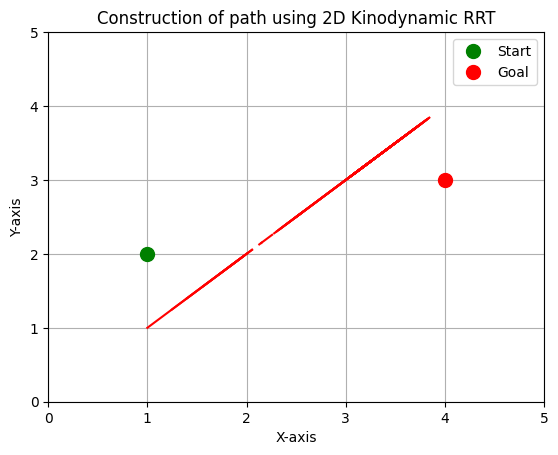

In [ ]:
x0 = np.array([1, 2])
goal = np.array([4,3])
path = kinodynamic_rrt(x0, goal)


## Simulation

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt


def kinodynamic_rrt(x0, goal, N=6000, p=4):
    def sample():
        return np.array([random.uniform(0, p), random.uniform(0, p)])

    def nearest(T, x_rand):
        return min(T, key=lambda x: np.linalg.norm(x - x_rand))

    def choose_control(x_near, x_rand):
        return (x_rand - x_near) * 0.1

    def simulate(x_near, u_e):
        return x_near + u_e

    def is_collision_free(x_near, x_e):
        # There are no obstacles in this example, so it's always collision-free
        return True

    def reconstruct_path(tree, x_e):
        path = [x_e]
        while x_e is not None:
            x_e = tree[x_e]
            path.append(x_e)
        return path[::-1]

    # RRT algorithm
    tree = {tuple(x0): None}

    for i in range(N):
        x_rand = sample()
        x_near = nearest(tree.keys(), x_rand)
        u_e = choose_control(x_near, x_rand)
        x_e = simulate(x_near, u_e)

        if is_collision_free(x_near, x_e):
            tree[tuple(x_e)] = x_near

            if np.linalg.norm(x_e - goal) < 0.1:
                print("Path found!")
                print("")
                path = reconstruct_path(tree, tuple(x_e))
                break
    else:
        print("No path found")
        print("")


    if 'path' in locals() and path is not None:
        path_x, path_y = [path[1:][i][0] for i in range(len(path[1:]))],[path[1:][i][1] for i in range(len(path[1:]))]
  

    return (path_x, path_y)

In [ ]:
random.seed(1234)

In [ ]:
# Example usage
x0 = np.array([0, 0])
milestones = [np.array([2, 3]), np.array([1, 4])]
p1 = kinodynamic_rrt(x0, milestones[0])
p2 = kinodynamic_rrt(milestones[0], milestones[1])



Path found!



KeyboardInterrupt: ignored

In [ ]:
plt.figure()
plt.plot(p1[0], p1[1], "o-")
plt.plot(p2[0], p2[1], "o-")
#plt.plot(p3[0], p3[1], "o-")

plt.plot(x0[0], x0[1], 'go', markersize=10, label='Start')

for i, milestone in enumerate(milestones):
  plt.plot(milestone[0], milestone[1], 'ro', markersize=10, label='Milestone'+str(i))


plt.legend()
plt.axis(True)
plt.show()